# Test Out a Nueral Network
Nonlinear features seem to be important for the machine learning model, as evident from the performance of linear models with polynomial features. Maybe we could do better by learning nonlinear combinations automatically with neural networks

In [1]:
%matplotlib inline
from stopping_power_ml.parsl import make_keras_picklable
make_keras_picklable()

from tqdm import tqdm_notebook as tqdm
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from itertools import product
from scipy import stats
import tensorflow as tf
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

/home/wardlt/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import parsl
import logging
from parsl import *
from parsl.configs.local import localIPP as config
#from parsl_config import config
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])
print("Parsl version : ", parsl.__version__)

Parsl version :  0.5.0


/home/wardlt/miniconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@js-156-80.jetstream-cloud.org')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


## Load in the Training Data
We are going to train on the random trajectory

In [3]:
data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [4]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

Remove the initial transient

In [5]:
data.query('initial == False', inplace=True)
print('Training set size:', len(data))

Training set size: 7274


Determine which columns are inputs

In [6]:
featurizers = pkl.load(open(os.path.join('..', '..', 'featurizers.pkl'), 'rb'))[:-1]

In [7]:
X_cols = sum([x.feature_labels() for x in featurizers], [])

In [8]:
y_col = 'force'

## Create initial network design
We're going to make a function that generates a network, so that tuning it will be easier later.

Our network will have two paths
1. Conventional Dense NN with nonlinear activations
2. A linear-regression-like layer: single layer with linear activations

This will allow for the model to easily learn the linear relationship between stopping force and ion-ion repulsion

In [9]:
from stopping_power_ml.keras import build_fn

In [10]:
print(build_fn.__doc__)

Creates a Keras NN model
    
    Args:
        input_size (int) - Number of features in input vector
        dense_layers ([int]) - Number of units in the dense layers
        activation (str) - Activation function in the dense layers
        use_linear_block (bool) - Whether to use the linear regression block
    


In [11]:
model = build_fn(len(X_cols), [10,10], 'linear', True)
model_nolin = build_fn(len(X_cols), [10,10], 'linear', False)

### Initial Test
Train the model on the whole dataset, make sure it can fit our data accurately

In [12]:
%%time
train_history = model.fit(data[X_cols], data[y_col], epochs=5000, verbose=0, validation_split=0.5,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                                 patience=100, verbose=0, mode='auto')])

CPU times: user 2min 52s, sys: 38.4 s, total: 3min 30s
Wall time: 1min 56s


In [13]:
print('Number of epochs:', len(train_history.epoch))

Number of epochs: 409


In [14]:
y_pred = model.predict(data[X_cols])

Plot the learning curve

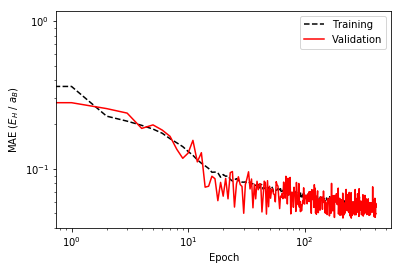

In [15]:
fig, ax = plt.subplots()

ax.loglog(train_history.epoch, train_history.history['mean_absolute_error'], 'k--', label='Training')
ax.loglog(train_history.epoch, train_history.history['val_mean_absolute_error'], 'r', label='Validation')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.set_yscale('log')

ax.legend()

Run the model without the linear blocks, for comparision

In [16]:
%%time
model_nolin.fit(data[X_cols], data[y_col], epochs=5000, verbose=0, validation_split=0.5,
                callbacks=[keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                         patience=100, verbose=0, mode='auto')])
y_pred_nolin = model_nolin.predict(data[X_cols])

CPU times: user 4min 43s, sys: 1min 5s, total: 5min 49s
Wall time: 3min 15s


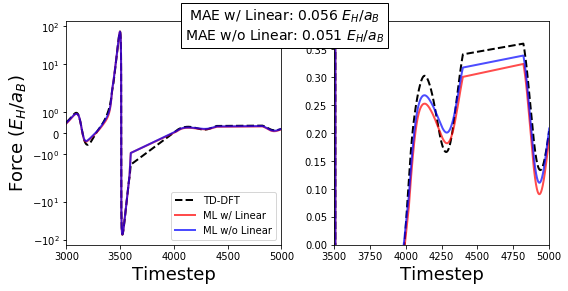

In [17]:
fig, axs = plt.subplots(1, 2)

for ax in axs:
    ax.plot(data['timestep'], data[y_col], 'k--', lw=2, label='TD-DFT')
    ax.plot(data['timestep'], y_pred, 'r-', alpha=0.7, lw=2, label='ML w/ Linear')
    ax.plot(data['timestep'], y_pred_nolin, 'b-', alpha=0.7, lw=2, label='ML w/o Linear')
    
# Make the right plot zoomed in
axs[1].set_ylim([0,0.4]) # Make sure the scales stay appropriate
axs[1].set_xlim(3500, 5000)

# Make the left plot a semilog, focusing on the region with the 
axs[0].set_xlim(3000, 5000)
axs[0].set_yscale('symlog')

# Add some annotations
traj_error = np.abs(np.squeeze(y_pred) - data[y_col]).mean()
traj_error_nolin = np.abs(np.squeeze(y_pred_nolin) - data[y_col]).mean()

fig.text(0.5, 1.0, 'MAE w/ Linear: %.3f $E_H/a_B$\nMAE w/o Linear: %.3f $E_H/a_B$'%(traj_error, traj_error_nolin), fontsize=14,
         ha='center', va='top',
       bbox=dict(edgecolor='k', facecolor='w'), transform=ax.transAxes)

for ax in axs:
    ax.set_xlabel('Timestep', fontsize=18)
axs[0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)
axs[0].legend(loc='lower right')

fig.set_size_inches(8, 4)
fig.tight_layout()

### Check how it does on the channel
Just see if we get something reasonable.

In [18]:
channel_data = channel_data[channel_data['average_range']]

In [19]:
channel_pred = model.predict(channel_data[X_cols])
channel_pred_nolin = model_nolin.predict(channel_data[X_cols])

Text(0,0.5,'Force ($E_H/a_B$)')

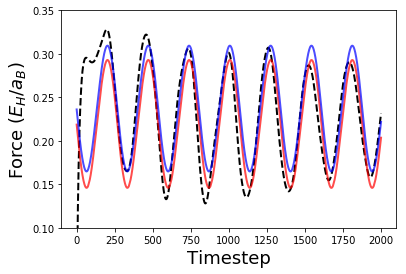

In [20]:
fig, ax = plt.subplots()

ax.plot(channel_data['timestep'], channel_data[y_col], 'k--', lw=2)
ax.plot(channel_data['timestep'], channel_pred, 'r-', alpha=0.7, lw=2)
ax.plot(channel_data['timestep'], channel_pred_nolin, 'b-', alpha=0.7, lw=2)

ax.set_ylim(0.1, 0.35)

ax.set_xlabel('Timestep', fontsize=18)
ax.set_ylabel('Force ($E_H/a_B$)', fontsize=18)

Seems reasonable enough

In [21]:
del model # No longer needed

## Optimize the Network
Get the optimal layer sizes for the network and the best activation

In [22]:
skl_model = KerasRegressor(build_fn, input_size=len(X_cols), epochs=5000, verbose=0,
                          callbacks=[keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto')])

Make an architecture generator

In [23]:
def make_architectures(layer_sizes=(32,16,8), min_depth=1, max_depth=3):
    """Generate a series of neural network architectures
    
    Rules: Layers must decrease in size with depth
    
    Args:
        layer_sizes ([int]) - Acceptable number of layers in a hidden unit
        min_depth (int) - Minimum depth of the network
        max_depth (int) - Maximum depth of the network
    Output:
        Generates ((int)), which define a dense NN shape
    """
    if max_depth == 0:
        yield ()
    else:
        # Sort the layer sizes
        layer_sizes = sorted(layer_sizes, reverse=True)

        # Loop through all depths
        for depth in range(min_depth, max_depth + 1, 1):
            # Loop through all layer sizes
            for layer_ind, my_size in enumerate(layer_sizes):
                # Generate my layer size
                network = (my_size,)

                # Generate all possible sublayers
                for subarch in make_architectures(layer_sizes[layer_ind:], depth-1, depth-1):
                    yield network + subarch
for arch in make_architectures():
    assert (np.diff(arch) <= 0).all()

In [24]:
%%time
archs = list(make_architectures())
print('Generated %d architectures'%len(archs))

Generated 19 architectures
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 417 µs


Determine the best architecture

In [25]:
test_split = 0.25

In [26]:
train_data, test_data = train_test_split(data, test_size=test_split, shuffle=False)

In [27]:
designs = ParameterGrid({
    'dense_layers': archs,
    'use_linear_block': [True, False]
})

In [28]:
@App('python', dfk)
def test_design(design, train_data, test_data, skl_model=skl_model, X_cols=X_cols, y_col=y_col):
    import numpy as np
    # Update the parameters
    skl_model.set_params(**design)
    
    # Fit the model
    skl_model.fit(train_data[X_cols], train_data[y_col])

    # Run the model
    y_pred = skl_model.predict(test_data[X_cols])
    return np.abs(y_pred - test_data[y_col]).mean()

In [29]:
def eval_designs(designs):
    """Evaluate a series of NN designs
    
    Args:
        designs ([dict]) - List of designs to test
    Returns:
        (dict) best design"""
    
    # In case designs is a generator or set
    designs = list(designs)
    
    # Send out the designs to processors
    futures = [test_design(design, train_data, test_data) for design in designs]
    
    # Get the results
    maes = [f.result() for f in tqdm(futures)]
    
    # Return the best design
    return designs[np.argmin(maes)]

In [30]:
best_design = eval_designs(designs)
print('Best Design', best_design)


Best Design {'dense_layers': (32, 8, 8), 'use_linear_block': True}


In [31]:
skl_model.set_params(**best_design)

Study different activations

In [32]:
designs = ParameterGrid({
    'activation': ['linear', 'tanh', 'softmax', 'softplus', 'sigmoid']
})

In [33]:
%%time
best_design = eval_designs(designs)
print('Best Design', best_design)


Best Design {'activation': 'sigmoid'}
CPU times: user 648 ms, sys: 84 ms, total: 732 ms
Wall time: 11min 51s


In [34]:
skl_model.set_params(**best_design)
skl_model.get_params()

{'input_size': 15,
 'epochs': 5000,
 'verbose': 0,
 'callbacks': [<keras.callbacks.EarlyStopping at 0x7f8eb5048dd8>],
 'dense_layers': (32, 8, 8),
 'use_linear_block': True,
 'activation': 'sigmoid',
 'build_fn': <function stopping_power_ml.keras.build_fn(input_size=10, dense_layers=(10, 10), activation='linear', use_linear_block=True)>}

## Make a Training Movie
Plot the change in fitness as more data is added

In [35]:
frames = np.linspace(10, len(data) / 2, 50, dtype=np.int)

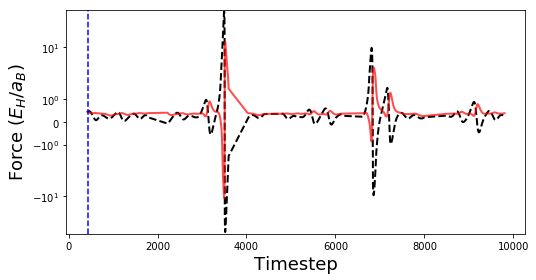

In [36]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force'], 'k--', lw=2)

skl_model.fit(data[X_cols].iloc[:3], data[y_col].iloc[:3])
lne, = ax.plot(data['timestep'], skl_model.predict(data[X_cols]), 'r-', alpha=0.7, lw=2)
ax.set_ylim(ax.get_ylim())
bar, = ax.plot([data['timestep'].iloc[:1].max(),]*2, ax.get_ylim(), 'b--')

def update(frame, skl_model):
    size = frames[frame]
    skl_model.fit(data[X_cols].iloc[:size], data[y_col].iloc[:size])
    lne.set_data(data['timestep'], skl_model.predict(data[X_cols]))
    
    bar.set_data([data['timestep'].iloc[:size].max(),]*2, ax.get_ylim())
    return lne, bar
    
anim = FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True, fargs=[skl_model])

ax.set_yscale('symlog')
ax.set_xlabel('Timestep', fontsize=18)
ax.set_ylabel('Force ($E_H/a_B$)', fontsize=18)
fig.tight_layout()
fig.set_size_inches(8, 4)

In [37]:
HTML(anim.to_html5_video())

This video shows the changes in the fitness of the model as we add new training data. In each frame, the model is trained using all of the data to the left of the blue bar. The black line is the TD-DFT result and the red line in the ML prediction. Notice how the model first starts to accurately predict the stopping power in low-force region and then accurately models the high force regions. After we gather about half of the training data, our model predictions no longer fluctuate with adding more data. 

In [38]:
anim.save(os.path.join('figures', 'training-animation.mp4'), dpi=330, writer='ffmpeg')

/home/wardlt/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning:

Method on_batch_end() is slow compared to the batch update (0.299686). Check your callbacks.

/home/wardlt/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning:

Method on_batch_end() is slow compared to the batch update (0.149865). Check your callbacks.



## Train and Save the Best Model
This model will be used by subsequent tests. So, fit it on the whole dataset first

In [39]:
%%time
skl_model.fit(data[X_cols], data[y_col])

CPU times: user 27min 31s, sys: 4min 37s, total: 32min 8s
Wall time: 20min 31s


In [40]:
skl_model.model.save("model.h5")

In [41]:
with open('model.pkl', 'wb') as fp:
    skl_model.model = None
    pkl.dump(skl_model, fp)